In [1]:
!pip install gensim

In [2]:
import numpy as np
from sklearn.metrics import (
    cohen_kappa_score,
    explained_variance_score,
    mean_squared_error,
)


def calc_metrics(true: np.array, pred: np.array) -> dict:
    """Calculates all necesserary metrics

    Args:
        true (np.array): True ansers
        pred (np.array): Predicted answers

    Returns:
        dict: Dictionary with metrics
    """
    # The mean squared error
    mse = mean_squared_error(true, pred)

    # Explained variance score
    exp_var = explained_variance_score(true, pred)

    # Kappa score
    kappa = cohen_kappa_score(true, np.around(pred), weights="quadratic")

    return {"mse": mse, "explained_variance": exp_var, "kappa": kappa}

In [8]:
import pandas as pd
import numpy as np
import string, re
from collections import Counter

from gspread import authorize
import pandas as pd

from oauth2client.service_account import ServiceAccountCredentials

scopes = ["https://spreadsheets.google.com/feeds",
                  "https://www.googleapis.com/auth/spreadsheets",
                  "https://www.googleapis.com/auth/drive",
                  "https://www.googleapis.com/auth/drive"]


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [22]:
import scipy

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
def display_confusion_matrix(y_true, y_pred, model_name: str) -> None:

  confusion_matrix_data = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8,8))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_data, display_labels=sorted(np.unique(y_true)))
  cm_display.plot()
  plt.title(model_name)
  plt.show()

In [7]:
def read_from_gsheet():
    cred = ServiceAccountCredentials.from_json_keyfile_name('/content/drive/MyDrive/movs_project/credentials_googlesheets.json', scopes)
    gc = authorize(cred)
    sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1m0mc1H7ULIZ2HEkT4dha_XRmRjt0gWJ8aht_GJ2lxfw/edit#gid=0')
    ws = sheet.worksheet('Dataset')
    return pd.DataFrame(ws.get_all_records())

def drop_unwanted_data(df: pd.DataFrame):
    columns_to_drop = ['Comments', 'origin', 'task_image', 'score_image']
    columns = ['Solving a communicative task', 'Text structure', 'Use of English (for emails)', 'Lexis (essay)',
               'Grammatical accuracy (essay)', 'Punctuation and spelling (essay)']

    # Удаляем лишние столбцы (на данный момент)
    df = df.drop(columns=columns_to_drop)

    # Удаляем строки баллов, если там сожержатся другие значения, кроме int и float (избавимся от string)
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    return df

def split_types(df: pd.DataFrame):
    # Следующий этап - разделим на письма и эссе
    essay_df = df[df[' Type'] == 'Essay']
    email_df = df[df[' Type'] == 'Email']

    # и удалим лишние колонки для каждого типа
    essay_df = essay_df.drop(columns='Use of English (for emails)')
    email_df = email_df.drop(
        columns=['Lexis (essay)', 'Grammatical accuracy (essay)', 'Punctuation and spelling (essay)'])

    # Убираем NaN
    essay_df = essay_df.dropna()
    email_df = email_df.dropna()

    return essay_df, email_df

In [29]:
# Читаем данные из таблицы, удаляем неинтересующие столбцы, фильтруем по типу задания
raw_data = read_from_gsheet()
_, email_data = split_types(raw_data)

In [30]:
email_data = email_data[email_data['Text'].str.strip().astype(bool)] # Удалим строки с пустыми ответами
# email_data = email_data[email_data['Overall_score'] != 0]
email_data = email_data[~email_data['Question'].str.contains('[А-Яа-я]+', regex=True)]
email_data = email_data[email_data['Question'].notna()]
email_data = email_data[email_data['Question'] != '']
email_data["Text"] = email_data["Text"].apply(lambda x: re.sub(r'[^A-Za-z ]', ' ', x))

In [31]:
score_columns = ['Solving a communicative task']
for score_col in score_columns:
    email_data = email_data[pd.to_numeric(email_data[score_col], errors='coerce').notna()]
    email_data[score_col] = email_data[score_col].astype("float16")

In [34]:
email_data["input"] = email_data["Question"] + "\n" + email_data["Text"]

In [35]:
import logging
import re

import nltk
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors, Word2Vec
from nltk.corpus import stopwords

log = logging.getLogger(__name__)

def essay_to_wordlist(essay_v: str, remove_stopwords: bool) -> tuple:
    """Remove the tagged labels and word tokenize the sentence"""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if w not in stops]
    return words


def essay_to_sentences(essay_v: str, remove_stopwords: bool) -> list:
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences


def make_feature_vec(
    words: list, model: Word2Vec | KeyedVectors, num_features: int
) -> np.array:
    """Make ar from the words list of an Essay."""
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    if hasattr(model, "wv"):
        index2word_set = set(model.wv.index_to_key)
    else:
        index2word_set = set(model.index_to_key)

    for word in words:
        if word in index2word_set:
            num_words += 1
            if hasattr(model, "wv"):
                feature_vec = np.add(feature_vec, model.wv[word])
            else:
                feature_vec = np.add(feature_vec, model[word])
    feature_vec = np.divide(feature_vec, num_words)
    return feature_vec


def get_avg_feature_vecs(
    essays: list, model: Word2Vec | KeyedVectors, num_features: int
) -> np.array:
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essay_feature_vecs = np.zeros((len(essays), num_features), dtype="float32")
    for essay in essays:
        essay_feature_vecs[counter] = make_feature_vec(essay, model, num_features)
        counter += 1
    return essay_feature_vecs


def prep_train_data(train_data: pd.DataFrame, w2vec_path) -> tuple:
    """Prepare data for training

    Args:
        data (pd.DataFrame): Input raw dataframe

    Returns:
        tuple: Tuple of features np.array and answers np.array
    """
    log.info("NLTK punkt downloading started")
    nltk.download("punkt")
    log.info("Download finished.\n")
    log.info("NLTK punkt downloading started")
    nltk.download("stopwords")
    log.info("Download finished.\n")

    train_data = train_data.dropna(axis=1)
    scores = train_data["Solving a communicative task"]
    train_data = train_data["input"]

    sentences = []

    for essay in train_data:
        sentences += essay_to_sentences(essay, remove_stopwords=True)
    log.info("Training Word2Vec Model...")
    model = Word2Vec(
        sentences,
        workers=8,
        vector_size=300,
        min_count=40,
        window=10,
        sample=0.001,
    )
    log.info("Word2Vec Model trained successfully!")
    # model.init_sims(replace=True)
    log.info("Saving Word2Vec Model...")
    model.wv.save_word2vec_format(w2vec_path, binary=True)
    log.info("Word2Vec Model saved successfully!\n")

    clean_train_essays = []

    for essay_text in train_data:
        clean_train_essays.append(essay_to_wordlist(essay_text, remove_stopwords=True))
    train_vectors = get_avg_feature_vecs(
        clean_train_essays, model, 300
    )

    return np.array(train_vectors), np.array(scores)

In [79]:
X, y = prep_train_data(email_data, "./word2vecmodel.bin")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Линейная регрессия

In [47]:
# линейная регрессия
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}")
r_1 = np.corrcoef(y_test, y_pred)[0, 1] # коэффициент корреляции Пирсона для модели 1
rho_1 = scipy.stats.spearmanr(y_test, y_pred)[0] # коэффициент корреляции Спирмена для модели 1
print("r = {:.3f}, rho = {:.3f}".format(r_1, rho_1))

RMSE: 0.8119825720787048
r = 0.116, rho = 0.166


<Figure size 800x800 with 0 Axes>

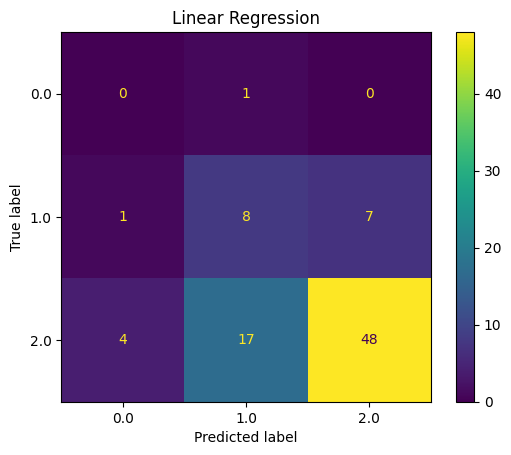

In [53]:
y_pred_int = np.where(y_pred < 2, y_pred, 2)
y_pred_int = np.where(y_pred_int > 0, y_pred_int, 0)
y_pred_int = np.round(y_pred_int)
display_confusion_matrix(y_test, y_pred_int, "Linear Regression")

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.31      0.50      0.38        16
           2       0.87      0.70      0.77        69

    accuracy                           0.65        86
   macro avg       0.39      0.40      0.39        86
weighted avg       0.76      0.65      0.69        86



# DecisionTree

In [60]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке и вычисление ошибки
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {mse}")

RMSE: 0.5603155257282213


<Figure size 800x800 with 0 Axes>

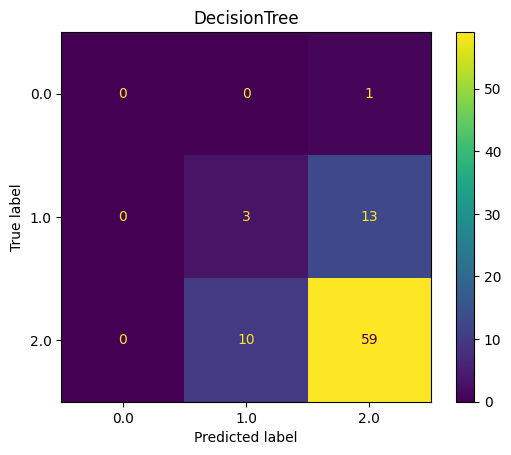

In [62]:
y_pred_int = np.where(y_pred < 2, y_pred, 2)
y_pred_int = np.where(y_pred_int > 0, y_pred_int, 0)
y_pred_int = np.round(y_pred_int)
display_confusion_matrix(y_test, y_pred_int, "DecisionTree")

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.23      0.19      0.21        16
           2       0.81      0.86      0.83        69

    accuracy                           0.72        86
   macro avg       0.35      0.35      0.35        86
weighted avg       0.69      0.72      0.71        86



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# RandomForest

In [56]:
# Фильтруем лингвистические признаки с помощью алгоритма Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}")
r_1 = np.corrcoef(y_test, y_pred)[0, 1] # коэффициент корреляции Пирсона для модели 1
rho_1 = scipy.stats.spearmanr(y_test, y_pred)[0] # коэффициент корреляции Спирмена для модели 1
print("r = {:.3f}, rho = {:.3f}".format(r_1, rho_1))

RMSE: 0.45966620852071993
r = 0.068, rho = 0.110


<Figure size 800x800 with 0 Axes>

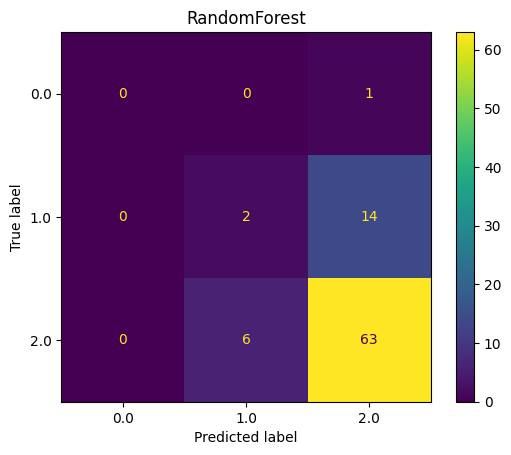

In [58]:
y_pred_int = np.where(y_pred < 2, y_pred, 2)
y_pred_int = np.where(y_pred_int > 0, y_pred_int, 0)
y_pred_int = np.round(y_pred_int)
display_confusion_matrix(y_test, y_pred_int, "RandomForest")

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.25      0.12      0.17        16
           2       0.81      0.91      0.86        69

    accuracy                           0.76        86
   macro avg       0.35      0.35      0.34        86
weighted avg       0.69      0.76      0.72        86



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM

In [84]:
from sklearn import svm
regr = svm.SVR()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}")
r_1 = np.corrcoef(y_test, y_pred)[0, 1] # коэффициент корреляции Пирсона для модели 1
rho_1 = scipy.stats.spearmanr(y_test, y_pred)[0] # коэффициент корреляции Спирмена для модели 1
print("r = {:.3f}, rho = {:.3f}".format(r_1, rho_1))

RMSE: 0.4478341020355339
r = 0.240, rho = 0.321


<Figure size 800x800 with 0 Axes>

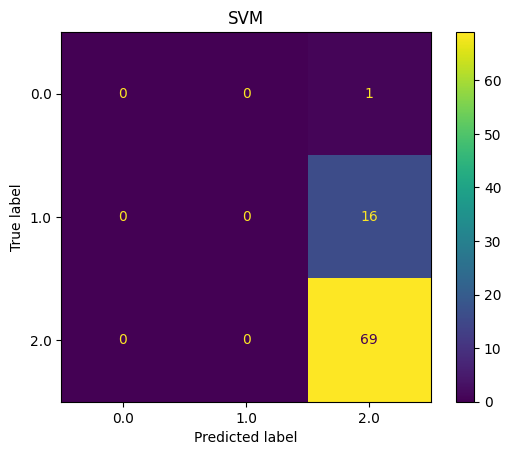

In [85]:
y_pred_int = np.where(y_pred < 2, y_pred, 2)
y_pred_int = np.where(y_pred_int > 0, y_pred_int, 0)
y_pred_int = np.round(y_pred_int)
display_confusion_matrix(y_test, y_pred_int, "SVM")

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        16
           2       0.80      1.00      0.89        69

    accuracy                           0.80        86
   macro avg       0.27      0.33      0.30        86
weighted avg       0.64      0.80      0.71        86



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TF-IDF

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(email_data["input"].values, email_data["Solving a communicative task"].values, test_size=0.2, random_state=42, stratify=y)

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=5, max_df=1.0, ngram_range=(1, 1))
tfidf.fit(X_train)

TfidfVectorizer(min_df=5)

In [89]:
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

X_train.shape, X_test.shape

((342, 844), (86, 844))

# Линейная регрессия

In [67]:
# линейная регрессия
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}")
r_1 = np.corrcoef(y_test, y_pred)[0, 1] # коэффициент корреляции Пирсона для модели 1
rho_1 = scipy.stats.spearmanr(y_test, y_pred)[0] # коэффициент корреляции Спирмена для модели 1
print("r = {:.3f}, rho = {:.3f}".format(r_1, rho_1))

RMSE: 0.5694739835599835
r = 0.169, rho = 0.099


<Figure size 800x800 with 0 Axes>

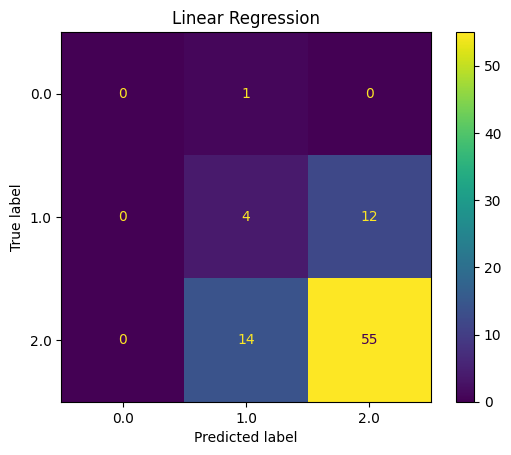

In [68]:
y_pred_int = np.where(y_pred < 2, y_pred, 2)
y_pred_int = np.where(y_pred_int > 0, y_pred_int, 0)
y_pred_int = np.round(y_pred_int)
display_confusion_matrix(y_test, y_pred_int, "Linear Regression")

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.21      0.25      0.23        16
           2       0.82      0.80      0.81        69

    accuracy                           0.69        86
   macro avg       0.34      0.35      0.35        86
weighted avg       0.70      0.69      0.69        86



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# DecisionTree

In [70]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке и вычисление ошибки
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {mse}")

RMSE: 0.5906244232186183


<Figure size 800x800 with 0 Axes>

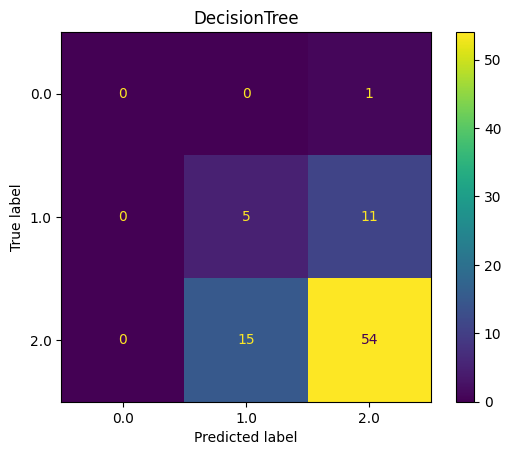

In [71]:
y_pred_int = np.where(y_pred < 2, y_pred, 2)
y_pred_int = np.where(y_pred_int > 0, y_pred_int, 0)
y_pred_int = np.round(y_pred_int)
display_confusion_matrix(y_test, y_pred_int, "DecisionTree")

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.25      0.31      0.28        16
           2       0.82      0.78      0.80        69

    accuracy                           0.69        86
   macro avg       0.36      0.37      0.36        86
weighted avg       0.70      0.69      0.69        86



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# RandomForest

In [73]:
# Фильтруем лингвистические признаки с помощью алгоритма Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}")
r_1 = np.corrcoef(y_test, y_pred)[0, 1] # коэффициент корреляции Пирсона для модели 1
rho_1 = scipy.stats.spearmanr(y_test, y_pred)[0] # коэффициент корреляции Спирмена для модели 1
print("r = {:.3f}, rho = {:.3f}".format(r_1, rho_1))

RMSE: 0.437071384728899
r = 0.139, rho = 0.143


<Figure size 800x800 with 0 Axes>

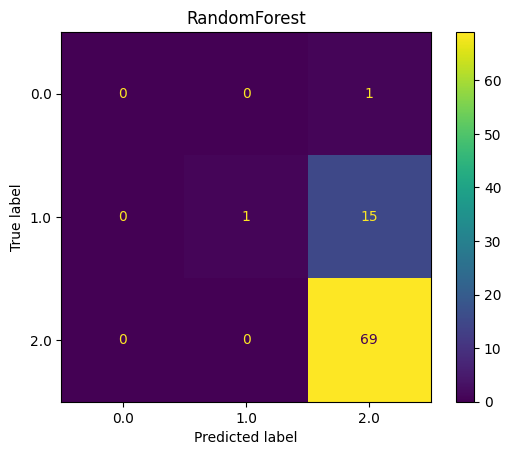

In [74]:
y_pred_int = np.where(y_pred < 2, y_pred, 2)
y_pred_int = np.where(y_pred_int > 0, y_pred_int, 0)
y_pred_int = np.round(y_pred_int)
display_confusion_matrix(y_test, y_pred_int, "RandomForest")

In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.06      0.12        16
           2       0.81      1.00      0.90        69

    accuracy                           0.81        86
   macro avg       0.60      0.35      0.34        86
weighted avg       0.84      0.81      0.74        86



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM

In [90]:
from sklearn import svm
regr = svm.SVR()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}")
r_1 = np.corrcoef(y_test, y_pred)[0, 1] # коэффициент корреляции Пирсона для модели 1
rho_1 = scipy.stats.spearmanr(y_test, y_pred)[0] # коэффициент корреляции Спирмена для модели 1
print("r = {:.3f}, rho = {:.3f}".format(r_1, rho_1))

RMSE: 0.4186648383041618
r = 0.268, rho = 0.212


<Figure size 800x800 with 0 Axes>

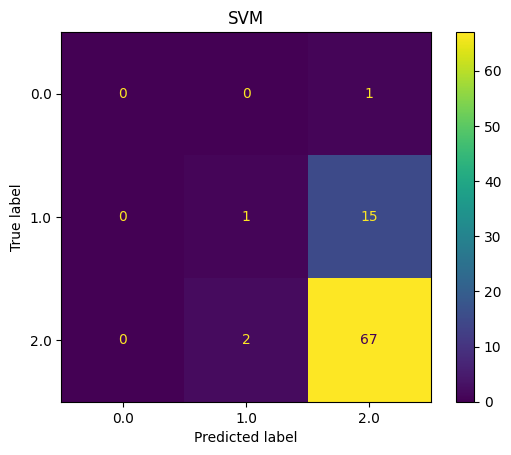

In [92]:
y_pred_int = np.where(y_pred < 2, y_pred, 2)
y_pred_int = np.where(y_pred_int > 0, y_pred_int, 0)
y_pred_int = np.round(y_pred_int)
display_confusion_matrix(y_test, y_pred_int, "SVM")

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      0.06      0.11        16
           2       0.81      0.97      0.88        69

    accuracy                           0.79        86
   macro avg       0.38      0.34      0.33        86
weighted avg       0.71      0.79      0.73        86



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
